In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from cdslm.plotting_utils import boxplot_with_pvals

In [4]:
cdslm_preds = pd.read_csv('CDS-LM_preds.csv', index_col=0)
saluki_preds = pd.read_csv('saluki_ensemble_preds.csv', index_col=0)
saluki_preds.rename(columns={'targets': 'y_true'}, inplace=True)

In [2]:
def bootstrap_binned(df: pd.DataFrame, n_bootstraps: int=100) -> pd.DataFrame:
    
    df_list = []
    for length_bin in range(5):
        target_df = df[df['LenBin'] == length_bin].copy()
        all_idxs = np.random.randint(0, len(target_df), size=(n_bootstraps, len(target_df)))
        boots = [target_df.take(i) for i in all_idxs]
        
        rho_list = [spearmanr(boot['preds'], boot['y_true'])[0] for boot in boots]
        bin_df = pd.DataFrame({'spearmanr': rho_list})
        bin_df['LenBin'] = length_bin
        df_list.append(bin_df)

    return pd.concat(df_list)
    

In [5]:
cdslm_data = bootstrap_binned(cdslm_preds, 10000)
cdslm_data['Model'] = 'CDS-LM'
saluki_data = bootstrap_binned(saluki_preds, 10000)
saluki_data['Model'] = 'Saluki'
data = pd.concat([cdslm_data, saluki_data])

<Axes: xlabel='LenBin', ylabel='spearmanr'>

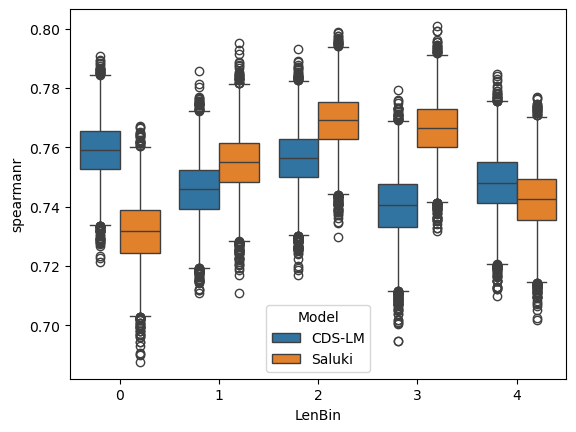

In [51]:
sns.boxplot(data=data, x='LenBin', y='spearmanr', hue='Model')

In [61]:
for length_bin in range(5):
    cdslm_lens = cdslm_data[cdslm_data['LenBin'] == length_bin]
    saluki_lens = saluki_data[saluki_data['LenBin'] == length_bin]
    
    boot_corr1 = cdslm_lens['spearmanr'].to_numpy()
    boot_corr2 = saluki_lens['spearmanr'].to_numpy()
    ci1 = np.percentile(boot_corr1, [2.5, 97.5])
    ci2 = np.percentile(boot_corr2, [2.5, 97.5])
    boot_diff = boot_corr1 - boot_corr2
    p_val = np.mean(boot_diff <= 0) if length_bin in [0, 4] else np.mean(boot_diff >= 0)
    
    print(f"Bin {length_bin}:")
    print(f"CDS-LM: {ci1[0]:.4f} < x < {ci1[1]:.4f}")
    print(f"Saluki: {ci2[0]:.4f} < x < {ci2[1]:.4f}")
    print(f"Bootstrap p-value: {p_val:.4f}")



boot_corr1 = cdslm_data['spearmanr'].to_numpy()
boot_corr2 = saluki_data['spearmanr'].to_numpy()
ci1 = np.percentile(boot_corr1, [2.5, 97.5])
ci2 = np.percentile(boot_corr2, [2.5, 97.5])
p_val = np.mean(boot_diff >= 0)
print(f"Overall:")
print(f"CDS-LM: {ci1[0]:.4f} < x < {ci1[1]:.4f}")
print(f"Saluki: {ci2[0]:.4f} < x < {ci2[1]:.4f}")
print(f"Bootstrap p-value: {p_val:.4f}")

Bin 0:
CDS-LM: 0.7400 < x < 0.7768
Saluki: 0.7104 < x < 0.7515
Bootstrap p-value: 0.0271
Bin 1:
CDS-LM: 0.7263 < x < 0.7651
Saluki: 0.7351 < x < 0.7740
Bootstrap p-value: 0.2554
Bin 2:
CDS-LM: 0.7367 < x < 0.7749
Saluki: 0.7506 < x < 0.7865
Bootstrap p-value: 0.1778
Bin 3:
CDS-LM: 0.7194 < x < 0.7605
Saluki: 0.7484 < x < 0.7841
Bootstrap p-value: 0.0307
Bin 4:
CDS-LM: 0.7278 < x < 0.7676
Saluki: 0.7219 < x < 0.7620
Bootstrap p-value: 0.3462
Overall:
CDS-LM: 0.7258 < x < 0.7727
Saluki: 0.7187 < x < 0.7818
Bootstrap p-value: 0.6538


In [62]:
print(np.median(boot_corr1))
np.median(boot_corr2)

0.7500601536383285


np.float64(0.7544258143855063)